# Traffic Analysis

&nbsp; &nbsp; &nbsp; &nbsp; Average Daily Traffic counts are analogous to a census count of vehicles on city streets. There counts provide a close approximation to the actual number of vehicles passing through a given location on an average weekday. Since it is not possible to count every vehicle on every city street, sample counts are taken along streets to get an estimate of traffic on half-mile or one-mile street segments.<br /> 

&nbsp; &nbsp; &nbsp; &nbsp; Herein, I will performed data cleaning and feature engineering, analyze the traffic data to answer the required questions and try to explore more.

In [125]:
# import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Table of Contents
1. [Load Data](#load)
2. [Data Cleaning and Feature Engineering](#cleaning)
3. [Q1: What's the busiest street?](#street)
4. [Q2: What's the busiest month?](#month)
5. [Q3: Is there a busiest direction?](#direction)
6. [Q4: What data cleaning and feature engineering steps did you take?](#feature)
7. [Q5: What else can you find out from this data?](#else)
8. [Summary of Preprocessing Data](#summary)
9. [Results and Insights](#result)


<a id='load'></a>
### 1. Load Data

In [921]:
# load data
data = pd.read_csv('C:/Users/xiaoj/Downloads/Average_Daily_Traffic_Counts.csv')
data.head()

,ID,Traffic Volume Count Location Address,Street,Date of Count,Total Passing Vehicle Volume,Vehicle Volume By Each Direction of Traffic,Latitude,Longitude,Location
0,2,1708 West,71st Street,3/9/2006,14600,East Bound: 6900 / West Bound: 7700,41.764877,-87.666635,"(41.764877, -87.666635)"
1,3,1275 West,71st Street,2/28/2006,16500,East Bound: 7800 / West Bound: 8700,41.765008,-87.657067,"(41.765008, -87.657067)"
2,5,920 West,71st Street,2/28/2006,18200,East Bound: 8800 / West Bound: 9400,41.765153,-87.647751,"(41.765153, -87.647751)"
3,6,758 West,71st Street,2/28/2006,21600,East Bound: 10400 / West Bound: 11200,41.765204,-87.644371,"(41.765204, -87.644371)"
4,7,240 East,71st St,2/28/2006,18300,East Bound: 9000 / West Bound: 9300,41.765644,-87.618476,"(41.765644, -87.618476)"


In [922]:
# check the null values and total data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1279 entries, 0 to 1278
Data columns (total 9 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   ID                                           1279 non-null   int64  
 1   Traffic Volume Count Location  Address       1279 non-null   object 
 2   Street                                       1279 non-null   object 
 3   Date of Count                                1279 non-null   object 
 4   Total Passing Vehicle Volume                 1279 non-null   int64  
 5   Vehicle Volume By Each Direction of Traffic  1279 non-null   object 
 6   Latitude                                     1279 non-null   float64
 7   Longitude                                    1279 non-null   float64
 8   Location                                     1279 non-null   object 
dtypes: float64(2), int64(2), object(5)
memory usage: 90.1+ KB


It can be seen that the data is not big (only 1279) and also there are non-null values. However, there are several obvious problems:
- The features' names are too long to take easily;
- The type of "Date of Count" is object instead of date;
- Vehicle volumes in the opposite directions are recorded in the same column;
- Some of the streets' names are inconsistent, such as Street vs. St;

I will firstly deal with these problems and explore more.

<a id='cleaning'></a>
## 2. Data Cleaning and Feature Engineering

In [924]:
# check all the columns
data.columns

Index(['ID ', 'Traffic Volume Count Location  Address', 'Street',
       'Date of Count', 'Total Passing Vehicle Volume',
       'Vehicle Volume By Each Direction of Traffic', 'Latitude', 'Longitude',
       'Location'],
      dtype='object')

In [925]:
# rename the column names
data = data.rename(columns = {"ID ":"ID", 'Traffic Volume Count Location  Address':"Address", 'Date of Count':'Date', 'Total Passing Vehicle Volume':'Total', 'Vehicle Volume By Each Direction of Traffic':'Direction'})

# check the result after renmaing
data.head()

,ID,Address,Street,Date,Total,Direction,Latitude,Longitude,Location
0,2,1708 West,71st Street,3/9/2006,14600,East Bound: 6900 / West Bound: 7700,41.764877,-87.666635,"(41.764877, -87.666635)"
1,3,1275 West,71st Street,2/28/2006,16500,East Bound: 7800 / West Bound: 8700,41.765008,-87.657067,"(41.765008, -87.657067)"
2,5,920 West,71st Street,2/28/2006,18200,East Bound: 8800 / West Bound: 9400,41.765153,-87.647751,"(41.765153, -87.647751)"
3,6,758 West,71st Street,2/28/2006,21600,East Bound: 10400 / West Bound: 11200,41.765204,-87.644371,"(41.765204, -87.644371)"
4,7,240 East,71st St,2/28/2006,18300,East Bound: 9000 / West Bound: 9300,41.765644,-87.618476,"(41.765644, -87.618476)"


Checking the unique values can not only give us information about how many unique values of the feature has but also tell us which features can be used to count. From the following result, it can be found that the ID is unique feature for every data, which means it can be used to count when needed. 

In [173]:
# check the unique values of every feature
for i in data.columns:
    print("The nunique numbers of "+ i+ " is: " + str(data[i].nunique()))

The nunique numbers of ID is: 1279
The nunique numbers of Address is: 1203
The nunique numbers of Street is: 251
The nunique numbers of Date is: 95
The nunique numbers of Total is: 398
The nunique numbers of Direction is: 1223
The nunique numbers of Latitude is: 1272
The nunique numbers of Longitude is: 1275
The nunique numbers of Location is: 1276


In [174]:
# use the latitute and longitude to get the city information
import geocoder
def geo_rev(x):
    g=geocoder.osm([x['Latitude'], x['Longitude']],method = 'reverse').json
    if g:
        return g.get('city')
        
    else:
        return 'none'
data['city']=data[['Latitude','Longitude']].apply(geo_rev, axis=1)

In [175]:
# Check how many cities included
data['city'].value_counts()

Chicago    1266
Name: city, dtype: int64

In [176]:
data.head(3)

,ID,Address,Street,Date,Total,Direction,Latitude,Longitude,Location,city
0,2,1708 West,71st Street,3/9/2006,14600,East Bound: 6900 / West Bound: 7700,41.764877,-87.666635,"(41.764877, -87.666635)",Chicago
1,3,1275 West,71st Street,2/28/2006,16500,East Bound: 7800 / West Bound: 8700,41.765008,-87.657067,"(41.765008, -87.657067)",Chicago
2,5,920 West,71st Street,2/28/2006,18200,East Bound: 8800 / West Bound: 9400,41.765153,-87.647751,"(41.765153, -87.647751)",Chicago


In [210]:
# check the address of those with no city
data_no_city = data[data['city']!='Chicago']
for i in data_no_city['Location']:
    lat = i[1:-1].split(",")[0]
    long = i[1:-1].split(",")[1]
    print(i + ": " + geocoder.osm([lat,long], method = 'reverse').json.get('address'))

(41.692257, -87.720366): Breakfast Club, South Pulaski Road, Mount Greenwood, Oak Lawn, Lake Township, Cook County, Illinois, 60453, United States
(41.68508, -87.700584): Cash America Pawn, 11445, South Kedzie Avenue, Mount Greenwood, Merrionette Park, Worth Township, Cook County, Illinois, 60803, United States
(41.896495, -87.775191): Austin & Iowa SB, North Austin Boulevard, Ridgeland, Oak Park, Cook County, Illinois, 60302, United States
(41.908868, -87.804756): North & Harlem Plaza, West North Avenue, Oak Park, Cook County, Illinois, 60302, United States
(41.677257, -87.680696): 119th Street & Western, West 119th Street, Morgan Park, Blue Island, Calumet Township, Cook County, Illinois, 60406, United States
(41.735341, -87.693452): 2847, West 87th Street, Evergreen Park, Worth Township, Cook County, Illinois, 60805, United States
(41.987853, -87.846528): North East River Road, O'Hare, Park Ridge, Leyden Township, Cook County, Illinois, 60656, United States
(41.957636, -87.799463): 

It can be found from above information that those without city information are either township or park. Since there are only 13 data without city information, and the majority (98.98% = 1266 / 1279) of data belongs to Chicago city. I would like to focus our analysis on the city of Chicago.

In [428]:
# get the data in Chicago and update the data
data_chicago = data[data['city']=='Chicago'].reset_index(drop = True)

In [429]:
# drop some irrelevant columns
data_chicago = data_chicago.drop(['Location','city'],1)
data_chicago.head()

,ID,Address,Street,Date,Total,Direction,Latitude,Longitude
0,2,1708 West,71st Street,3/9/2006,14600,East Bound: 6900 / West Bound: 7700,41.764877,-87.666635
1,3,1275 West,71st Street,2/28/2006,16500,East Bound: 7800 / West Bound: 8700,41.765008,-87.657067
2,5,920 West,71st Street,2/28/2006,18200,East Bound: 8800 / West Bound: 9400,41.765153,-87.647751
3,6,758 West,71st Street,2/28/2006,21600,East Bound: 10400 / West Bound: 11200,41.765204,-87.644371
4,7,240 East,71st St,2/28/2006,18300,East Bound: 9000 / West Bound: 9300,41.765644,-87.618476


In [430]:
# change the date type from object to datetime
data_chicago['Date'] = pd.to_datetime(data_chicago['Date'])

# build new feature of year, month and day 
data_chicago['year'] = data_chicago['Date'].dt.year
data_chicago['month'] = data_chicago['Date'].dt.month
data_chicago['day'] = data_chicago['Date'].dt.day_name()
data_chicago = data_chicago.drop('Date', 1)

# check and review the data 
data_chicago.head()

,ID,Address,Street,Total,Direction,Latitude,Longitude,year,month,day
0,2,1708 West,71st Street,14600,East Bound: 6900 / West Bound: 7700,41.764877,-87.666635,2006,3,Thursday
1,3,1275 West,71st Street,16500,East Bound: 7800 / West Bound: 8700,41.765008,-87.657067,2006,2,Tuesday
2,5,920 West,71st Street,18200,East Bound: 8800 / West Bound: 9400,41.765153,-87.647751,2006,2,Tuesday
3,6,758 West,71st Street,21600,East Bound: 10400 / West Bound: 11200,41.765204,-87.644371,2006,2,Tuesday
4,7,240 East,71st St,18300,East Bound: 9000 / West Bound: 9300,41.765644,-87.618476,2006,2,Tuesday


In [451]:
data_chicago.to_csv('data_chicago_2016')

In [431]:
# Check the year distribution
data_chicago['year'].value_counts()

2006    1257
2007       9
Name: year, dtype: int64

In [432]:
# Check how many street are counted and how many times counted
data_chicago[data_chicago['year']==2007].groupby('Street')['ID'].count()

Street
51st St             1
Canal St            1
Clinton St          1
Congress Pkwy       1
Dearborn St         1
Hollywood Ave       1
Milwaukee Ave       1
State St            1
Stony Island Ave    1
Name: ID, dtype: int64

From the above two information, it is easily to find that most of data were recorded in 2006, only 0.71 (9/1263) were recorded in 2007. And there are only 9 streets recorded, and each of them were recorded once. So, I would like to make the 2nd assumption. This project will only focus on **the city of Chicago in 2006**.

In [520]:
data_chicago_06 = data_chicago[data_chicago['year']== 2006]
data_chicago_06 = data_chicago_06.drop('year',1).reset_index(drop = True)
data_chicago_06.shape

(1257, 9)

([0, 1, 2, 3, 4, 5], <a list of 6 Text major ticklabel objects>)

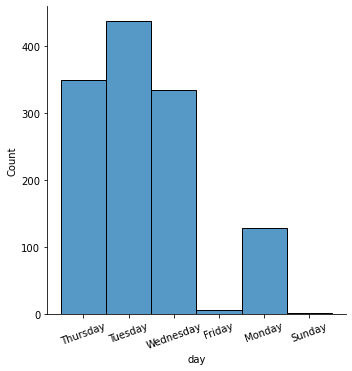

In [516]:
# check the day distribution
sns.displot(data_chicago_06['day'])
plt.xticks(rotation=20)

It can be found that most of the data were collected from Tues to Thurs, some were also collected on Monday. There are no data on Saturday and very few data on Friday and Sunday. I would like to focus on from Monday to Thursday in this project. Since they are working day. Since workday and weekend are really different for some streets, therefore if we want to invovle friday to sunday analysis, more data should be collected. 

In [503]:
data_chicago_06_day =data_chicago_06[data_chicago_06['day'].isin(['Monday','Tuesday','Wednesday','Thursday'])]
data_chicago_06_day.shape

(1251, 12)

In [442]:
# Split the 'Direction' features into four new features: two direction + corresponding volumes
data_chicago_06_day['0_direction'] = data_chicago_06_day['Direction'].str.split('/').str[0].str.split(':').str[0].str[:-6].str.strip()
data_chicago_06_day['0_volume'] = data_chicago_06_day['Direction'].str.split('/').str[0].str.split(':').str[1].astype(np.int64)
data_chicago_06_day['1_direction'] = data_chicago_06_day['Direction'].str.split('/').str[1].str.split(':').str[0].str[:-6].str.strip()
data_chicago_06_day['1_volume'] = data_chicago_06_day'Direction'].str.split('/ ').str[1].str.split(':').str[1].replace(np.nan, 0).astype(np.int64)
data_chicago_06_day = data_chicago_06_day.drop('Direction', 1)
data_chicago_06_day.head()

,ID,Address,Street,Total,Latitude,Longitude,month,day,0_direction,0_volume,1_direction,1_volume
0,2,1708 West,71st Street,14600,41.764877,-87.666635,3,Thursday,East,6900,West,7700
1,3,1275 West,71st Street,16500,41.765008,-87.657067,2,Tuesday,East,7800,West,8700
2,5,920 West,71st Street,18200,41.765153,-87.647751,2,Tuesday,East,8800,West,9400
3,6,758 West,71st Street,21600,41.765204,-87.644371,2,Tuesday,East,10400,West,11200
4,7,240 East,71st St,18300,41.765644,-87.618476,2,Tuesday,East,9000,West,9300


In [443]:
# check what kinds of values included in '0_direction'
data_chicago_06_day['0_direction'].value_counts()

North    635
East     554
South     38
West      30
Name: 0_direction, dtype: int64

In [444]:
# check what kinds of values included in '1_direction'
data_chicago_06_day['1_direction'].value_counts()

South           610
West            526
                 52
Oneway South     38
Oneway West      30
Oneway North      1
Name: 1_direction, dtype: int64

It is know that there should be at most four directions. However, there are more special situations in feature['1_direction']. I will unify these values. For example, since the "0_direction" and "1_direction" are splitted from the previous feature "direction", they should always be the opposite. When the total volumes is same with the volumes in ["0_direction"], it means that volumes of the opposite direction is 0 and vice verse.

In [446]:
# unify the direction in "1_direction"
dic={'South':"North","North":"South","East":"West","West":"East"}

for i in range(1251):   
    if data_chicago_06_day.loc[i,'Total']==data_chicago_06_day.loc[i,"0_volume"]:
        data_chicago_06_day.loc[i,'1_volume'] = 0
    data_chicago_06_day.loc[i,'1_direction'] = dic[data_chicago_06_day.loc[i,"0_direction"]]
data_chicago_06_day['1_direction'].value_counts()

South    635
West     554
North     38
East      30
Name: 1_direction, dtype: int64

In [447]:
# Check the abbreviation of the name of "Street" 
data_chicago_06_day['Street'].str.split(' ').str[-1].value_counts()

Ave           594
St            402
Rd             85
Street         50
Dr             50
Blvd           43
Broadway        7
Pkwy            3
ST              3
Ct              2
Hwy             2
L               2
O               2
Plaisance       2
83rdStreet      1
II              1
Plaissance      1
CT              1
rd)             1
pass)           1
Pl              1
(lower)         1
RD              1
PL              1
Name: Street, dtype: int64

Based on above information, it is easily to found that there are some duplicate abbreviations and some name are not abbreviated as expected. All can be summarized as following:
- Street: St;
- ST: St;
- RD: Rd;
- CT: Ct;
- PL: Pl;
- Plaissance: Plaisance;
- Western Ave (over pass): Western Ave;
- Wacker Dr (lower):Wacker Dr;
- Western Ave (frontage rd):vWestern Ave
- 83rdStreet: 83rd St

In [448]:
# modify the abbreviations of streets
data_chicago_06_day['Street']=data_chicago_06_day['Street'].replace({"Western Ave (over pass)":"Western Ave","Wacker Dr (lower)":"Wacker Dr", "Western Ave (frontage rd)":"Western Ave", "Plaissance":"Plaisance"},regex=False)
data_chicago_06_day['Street']=data_chicago_06_day['Street'].replace({'Street':'St', "ST":"St","RD":"Rd","CT":"Ct","PL":"Pl"},regex = True)
data_chicago_06_day['Street']=data_chicago_06_day['Street'].apply(lambda s: s.replace("83rdStreet","83rd  St"))
data_chicago_06_day['Street']=data_chicago_06_day['Street'].apply(lambda s: s.replace("Plaissance","Plaisance"))

data_chicago_06_day['Street'].str.split(' ').str[-1].value_counts()

Ave          596
St           455
Rd            86
Dr            51
Blvd          43
Broadway       7
Ct             3
Plaisance      3
Pkwy           3
Hwy            2
L              2
O              2
Pl             2
83rdSt         1
II             1
Name: Street, dtype: int64

In [220]:
data_chicago_06_day[data_chicag_06_day['Street'].str.split(' ').str[-1]=='L']

,ID,Address,Street,Date,Total,Latitude,Longitude,year,month,day,0_direction,0_volume,1_direction,1_volume
134,156,9621 South,Avenue L,2006-03-21,5000,41.720702,-87.536499,2006,3,Tuesday,North,3200,South,1800
135,157,10129 South,Avenue L,2006-03-21,4200,41.711118,-87.536485,2006,3,Tuesday,North,2100,South,2100


In [151]:
data_chicago_06_day[data_chicago_06_day['Street'].str.split(' ').str[-1]=='O']

,ID,Address,Street,Date,Total,Latitude,Longitude,year,month,day,0_direction,0_volume,1_direction,1_volume
696,751,11233 South,Avenue O,2006-10-18,16000,41.690863,-87.540104,2006,10,Wednesday,North,8100,South,7900
1191,1299,10928 South,Avenue O,2006-10-18,12400,41.696434,-87.540090,2006,10,Wednesday,North,7000,South,5400


In [152]:
# check the detailed information of "II"
data_chicago_06_day[data_chicago_06_day['Street'].str.split(' ').str[-1]=='II']

,ID,Address,Street,Date,Total,Latitude,Longitude,year,month,day,0_direction,0_volume,1_direction,1_volume
343,375,2701 West,Pope John Paul II,2006-05-09,7000,41.815579,-87.692019,2006,5,Tuesday,West,7000,East,0


In [449]:
# Check if the abbrivative has been changed
data_chicago_06_day['Street'].str.split(' ').str[-1].value_counts()

Ave          596
St           455
Rd            86
Dr            51
Blvd          43
Broadway       7
Ct             3
Plaisance      3
Pkwy           3
Hwy            2
L              2
O              2
Pl             2
83rdSt         1
II             1
Name: Street, dtype: int64

In [221]:
# save the datafile 
data_chicago.to_csv('data_chicago.csv')

## Q1: What is the busiest street?

In [577]:
# check the busiest street
data_chicago_06_day.groupby('Street')['Total'].sum().sort_values(ascending = False).head(1)

Street
Western Ave    1116100
Name: Total, dtype: int64

Based on all the data we have, it is easily to find that the busiest street is "Western Ave". However, since this is sample counts that will be taken to used to estimate the whole traffic in future, I have to check the counts distribution and if the sample is selected randomly as following.

In [523]:
# Street Vs. count times
data_chicago_06_day['Street'].value_counts()

Damen Ave            33
Western Ave          33
Ashland Ave          30
Halsted St           26
Pulaski Rd           26
                     ..
Yates Blvd            1
South Chicago Ave     1
95Th St               1
57th St               1
106th St              1
Name: Street, Length: 229, dtype: int64

(0.0, 35.0)

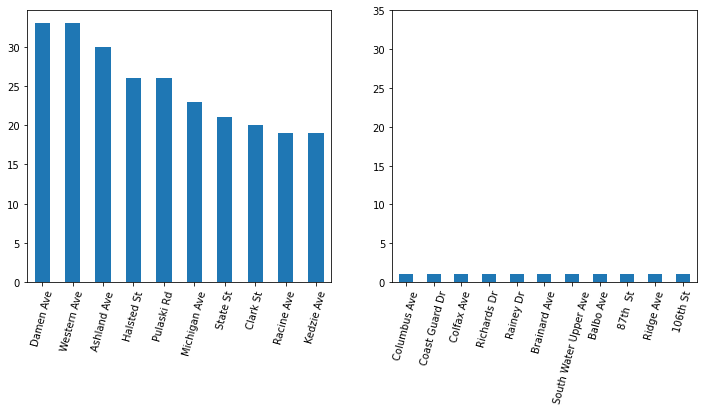

In [526]:
# visualization of streets's name Vs. Count numbers
fig,ax = plt.subplots(1,2,figsize=(12,5))

data_chicago_06_day['Street'].value_counts().sort_values(ascending=False).head(10).plot(kind='bar',ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=75)

data_chicago_06_day['Street'].value_counts().sort_values(ascending=False).tail(11).plot(kind='bar',ax=ax[1])
plt.xticks(rotation=75)
plt.ylim(0,35)

From the above information, it is easily to find that streets are not counted randomly,for example, some streets are counted too many times compared with others, while some streets are only counted once,which has raise a severe **selection bias** problem.

In [529]:
# The distribution of count numbers of streets
import collections
street_counts = data_chicago_06_day['Street'].value_counts().sort_values(ascending=False).values
collections.Counter(street_counts)

Counter({33: 2,
         30: 1,
         26: 2,
         23: 1,
         21: 1,
         20: 1,
         19: 2,
         18: 1,
         17: 3,
         16: 1,
         15: 2,
         14: 3,
         13: 5,
         12: 5,
         11: 5,
         10: 7,
         9: 12,
         8: 7,
         7: 12,
         6: 13,
         5: 7,
         4: 12,
         3: 18,
         2: 25,
         1: 81})

Text(0, 0.5, 'Frequency')

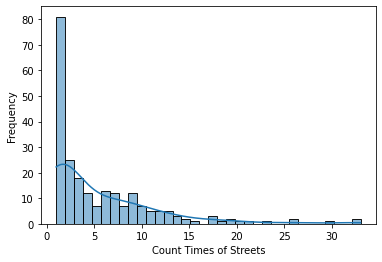

In [530]:
# Visulation of distribution of counts numbers of streets
sns.histplot(street_counts, kde=True,bins =34)
plt.xlabel('Count Times of Streets')
plt.ylabel('Frequency')

In [654]:
# find the threshold values of count times to get the maximum data, 
final_count = {}

# i is count times of street
for i in range(1,34):
    data_chicago_06_day_ = data_chicago_06_day.groupby('Street')['ID'].count()[data_chicago_06_day.groupby('Street')['ID'].count()>=i]
    # how many data I can get when I set i as count times 
    final_count[i] = i * data_chicago_06_day_.shape[0]
    
# to get the maximum data, which count times should be chose 
print("The best count times of the streets is: %d"%max(final_count, key=final_count.get))
print("The maximum data we can use is: %d" %max(final_count.values()))

The count times of the streets is: 6
The maximum data we can use is: 516


(0.0, 570.0)

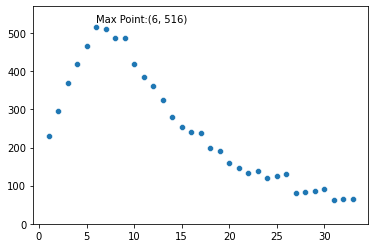

In [658]:
# Visualization of the relationship between count times and maximum data we can use
x = np.array(list(final_count.keys()))
y = np.array(list(final_count.values()))
sns.scatterplot(x=x,y=y)

plt.text(xmax,ymax+15,'Max Point:(6, 516)')
plt.ylim(0, 570)

Based on the above analysis, to get the most data and avoid data waste, I would choose 6 as the count times, which means only those strees that were recorded 6 times would be chosen for further analysis. And for those whose records history were less than 6 will be dropped, and for those whose records history were greater than 6, 6 records will be randomly chose from their total count times records. For example, "Western Ave" was found to be the most busiest street, because it was counted 33 times, which brought the selection bias problem. To deal with this problem, only 6 were selected randomly from 33.

In [873]:
data_chicago_06_day_ = data_chicago_06_day.groupby('Street')['ID'].count()[data_chicago_06_day.groupby('Street')['ID'].count()>=6]
data_chicago_06_day_

Street
103rd St         18
107th St         10
111th St         12
115th St         10
119th St          6
                 ..
Washington St    26
Wells St         20
Wentworth Ave    12
Western Ave      66
Woodlawn Ave      8
Name: ID, Length: 123, dtype: int64

In [874]:
# get the dataset in which every street are counted 6 times
data_final = data_chicago_06_day[data_chicago_06_day['Street']=="103rd St"].sample(6,random_state=42)

for i in data_chicago_06_day_.index[1:]:
    new = data_chicago_06_day[data_chicago_06_day['Street']==i].sample(6,random_state=42)    
    data_final = pd.concat([new, data_final])
    
data_final.shape

(738, 10)

<a id='street'></a>
## Q1: What is the busiest street?

In [705]:
data_final.groupby('Street')['Total'].sum().sort_values(ascending = False).head(5)

Street
Stony Island Ave    342400
Cicero Ave          263500
Cumberland Ave      244000
Western Ave         222900
Irving Park Rd      219600
Name: Total, dtype: int64

In [761]:
# get the dataset in which every street are counted 6 times
data_final = data_chicago_06_day[data_chicago_06_day['Street']=="103rd St"].sample(6)

for i in data_chicago_06_day_.index[1:]:
    new = data_chicago_06_day[data_chicago_06_day['Street']==i].sample(6)    
    data_final = pd.concat([new, data_final])
    
data_final.groupby('Street')['Total'].sum().sort_values(ascending = False).head(5)

Street
Cicero Ave          375800
Stony Island Ave    357800
Cumberland Ave      254900
Irving Park Rd      228800
Western Ave         218300
Name: Total, dtype: int64

In [767]:
data_chicago_06_day_2 = data_chicago_06_day.groupby('Street')['ID'].count()[data_chicago_06_day.groupby('Street')['ID'].count()>=10]
data_chicago_06_day_2.index
data_final = data_chicago_06_day[data_chicago_06_day['Street']=="31st St"].sample(6)

for i in data_chicago_06_day_2.index[1:]:
    new = data_chicago_06_day[data_chicago_06_day['Street']==i].sample(6)    
    data_final = pd.concat([new, data_final])
    
data_final.groupby('Street')['Total'].sum().sort_values(ascending = False).head(5)

Street
Stony Island Ave    243900
Cumberland Ave      236400
Cicero Ave          234500
Western Ave         229800
North Ave           228100
Name: Total, dtype: int64

In [869]:
data_chicago_06_day_2 = data_chicago_06_day.groupby('Street')['ID'].count()[data_chicago_06_day.groupby('Street')['ID'].count()>=14]
data_chicago_06_day_2.index
data_final = data_chicago_06_day[data_chicago_06_day['Street']=="31st St"].sample(6)

for i in data_chicago_06_day_2.index[1:]:
    new = data_chicago_06_day[data_chicago_06_day['Street']==i].sample(6)    
    data_final = pd.concat([new, data_final])
    
data_final.groupby('Street')['Total'].sum().sort_values(ascending = False).head(5)

Street
Stony Island Ave    304400
Cicero Ave          286400
Irving Park Rd      232000
Western Ave         204000
Fullerton Ave       194500
Name: Total, dtype: int64

The most busiest street on workday in Chicago in 2006 is "Stony Island Ave". The current results is based on those streets that has 6 count times. When I increase the count times from 6 to 7, the most busiest street is more stable. 

However, if we can collect more data, such as more data on weekend and more count times for every street, we can get more accurate analysis.For example, we can know what is the busiest street on workday and weekend. If we also have detailed count times in a day, we can know what is the busiest time in a day etc..

<a id='month'></a>
## Q2: What is the busiest month?

In [878]:
data_final['month'].value_counts()

10    199
8     158
3     137
9     126
11     51
4      33
5      26
2       5
12      2
7       1
Name: month, dtype: int64

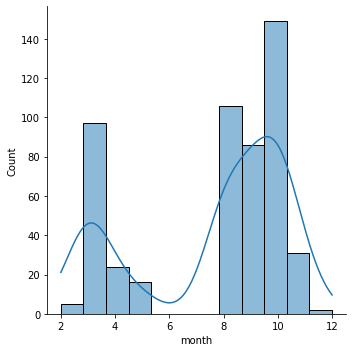

In [711]:
sns.displot(data_final['month'],bins =12,kde=True)

Since the counts are not distributed uniformly in each month, most were collected in Mar., Aug., Sep., and Oct., to avoid selection bias which can bring false result, I would like to choose these four month as representatve and check which month is the busiest. However, since the count times in these 4 monthes also showed some difference, such as the count numbers in March are nearly 70% of that in Oct, to avoid the possible selection biase, I would like to choose 150 randomly from Aug. and Oct.

In [883]:
data_final_month = data_final[data_final['month'].isin([3,8,9,10])]
data_final_month.shape

(620, 10)

In [887]:
data_final_8 = data_final_month[data_final_month['month']==8].sample(150)
data_final_10 = data_final_month[data_final_month['month']==10].sample(150)

data_final_month = pd.concat([data_final_month[data_final_month['month'].isin([3,9])],data_final_8,data_final_10])
data_final_month.shape

(563, 10)

In [898]:
data_final_month.groupby('month')["Total"].sum().sort_values(ascending = False)

month
8     3223700
10    2722700
9     2678800
3     2099300
Name: Total, dtype: int64

In [919]:
data_final_8 = data_final_month[data_final_month['month']==8].sample(150)
data_final_10 = data_final_month[data_final_month['month']==10].sample(150)

data_final_month = pd.concat([data_final_month[data_final_month['month'].isin([3,9])],data_final_8,data_final_10])
data_final_month.groupby('month')["Total"].sum().sort_values(ascending = False)

ValueError: Cannot take a larger sample than population when 'replace=False'

<a id='direction'></a>
## Q3: Which direction is the busiest one(N,S,E,W)?

In [732]:
data_final_0 = data_final.drop(['1_direction',"1_volume"],axis=1)
data_final_0 = data_final_0.rename(columns = {'0_direction':"direction","0_volume":"volume"})

data_final_1 = data_final.drop(['0_direction',"0_volume"],axis=1)
data_final_1 = data_final_0.rename(columns = {'1_direction':"direction","1_volume":"volume"})

data_final_dir = pd.concat([data_final_0,data_final_1])
data_final_dir.shape

(1032, 10)

In [736]:
data_final_dir.groupby('direction')['volume'].sum().sort_values(ascending = False)

direction
East     5033000
North    4814200
West      425200
South     230800
Name: volume, dtype: int64

In [757]:
data_chicago_06_day_0 = data_chicago_06_day.drop(['1_direction',"1_volume"],axis=1)
data_chicago_06_day_0 = data_chicago_06_day_0.rename(columns = {'0_direction':"direction","0_volume":"volume"})

data_chicago_06_day_1 = data_chicago_06_day.drop(['0_direction',"0_volume"],axis=1)
data_chicago_06_day_1 = data_chicago_06_day_1.rename(columns = {'1_direction':"direction","1_volume":"volume"})

data_chicago_06_day = pd.concat([data_chicago_06_day_0, data_chicago_06_day_1])
data_chicago_06_day.groupby('direction')['volume'].sum().sort_values(ascending = False)

direction
South    6837100
North    6806000
West     5313600
East     5194300
Name: volume, dtype: int64

In [920]:
data_final.head()

,ID,Address,Street,Total,Latitude,Longitude,month,day,direction,volume
344,377,5224 South,Woodlawn Ave,7200,41.800125,-87.596657,5,Tuesday,North,3500
344,377,5224 South,Woodlawn Ave,7200,41.800125,-87.596657,5,Tuesday,South,3700
338,371,5121 South,Woodlawn Ave,8100,41.801676,-87.596690,5,Thursday,North,4000
346,379,4624 South,Woodlawn Ave,3000,41.810689,-87.596855,5,Tuesday,South,1500
345,378,4929 South,Woodlawn Ave,5500,41.805123,-87.596753,5,Tuesday,North,2900


<a id='direction'></a>
## Q4: Which else?
- What is the busiest street in the busiest month?
- What is the busiet street in the busiest direction?
- What is the busiest street in each direction?
- How far is the busiest street with the second busiest street?
- What's the situation when compared east-west direction with south-north direction?

<a id='4.1'></a>
### Q4.1: What is the busiest street in the busiest month?

<a id='4.2'></a>
### Q4.2: What is the busiest street in the busiest direction?

<a id='4.3'></a>
### Q4.3: What is the busiest street in each direction?

<a id='4.4'></a>
### Q4.4: How far is the busiest street with the second busiest street?

<a id='4.5'></a>
### Q4.5: What's the situation when compared east-west direction with south-north direction?

<a id='summary'></a>
## Summary of Preprocessing Data

According to the above analysis, I have performed the following to prepare the data:

1). Cleaning the data
- Convert the data type;
- Replace the NaN values using 0 instead of dropping them;
- Split the string to get the specific information;
- Unify the abbreviation names in the feature;


2). Engineering feature
- Convert the latitude and longitude to detailed city or address;
- Transfer date to the year, month and day;
- Split the feature to get more detailed information;
- Concatenate the direction feature in the same column;


3). Dealing with selection bias

- There are a lot of selection bias problems in this dataset, such as city, year, month, day, street etc. 


- For some of them, it is easier to just keep the majority data since very few data differed from them. For example, I prefer this traffic analysis will focus on Chicago instead of Cook County since 99 % data belongs to the city of Chicago. And I also choose the study will be in 2006 since less than 1% data belonged to 2007. And I also choose this analysis will only focus on workday since there are less than 0.5% data focusing on weekend. 


- Then to get better understanding of the data, the distribution of street count times were studied. I randomly choose parts of streets count times to avoid the streets selection bias problem.

<a id='result'></a>
## Results and Insights

In this project, I propressed the traffic data and analyzed how the month and day affected the traffic volumes. The listed questions have been successfully answered. However, the results are not reliable enough. Because the data has severe **selective bias** problems, the collected data are mainly in Mar, Aug, Sep and Oct. and mainly ranged from monday to thursday. So, the conclusion about which momth/day is the busiest month/day is not reliable.But the answer about which direction is the business is reliable. Therefore, for the questions related on date, I would suggest:**1) collect more data; 2) avoid the selective bias;** then we can analyze the data again and give more accurate analysis.